# Bin filtering and normalization

In [1]:
from pytadbit.parsers.hic_parser import load_hic_data_from_bam

In [2]:
cell = 'mouse_B'
repl = 'rep1'

reso = 100000

In [3]:
hic_data = load_hic_data_from_bam(
    'results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}.bam'.format(cell, repl),
    reso, ncpus=8)


  (Matrix size 27269x27269)                                                    [2020-02-06 11:17:21]

  - Parsing BAM (122 chunks)                                                   [2020-02-06 11:17:21]
     .......... .......... .......... .......... ..........     50/122
     .......... .......... .......... .......... ..........    100/122
     .......... .......... ..                                  122/122

  - Getting matrices                                                           [2020-02-06 11:17:53]
     .......... .......... .......... .......... ..........     50/122
     .......... .......... .......... .......... ..........    100/122
     .......... .......... ..                                  122/122



## Filter bins with low interaction counts

In this case, the filtering we are applying is divided in two steps:
1. First we ask to remove all columns having a total of less than 10 interactions (`min_count=10`). This is a relatively loose filtering.
2. We apply a more complex filter. We will remove bins with a total number of counts much lower than the mean of the interaction counts.
 
*__Note__: For this (very sparse) dataset, we required very few (10) interactions per bin. In normal cases, to filter bins with too low interaction counts one should require that each bin contains a minimum percentage (default 75%) of cells with no-zero counts, or a minimum number of interactions in total (for good quality data the recommended value could be 2500).*

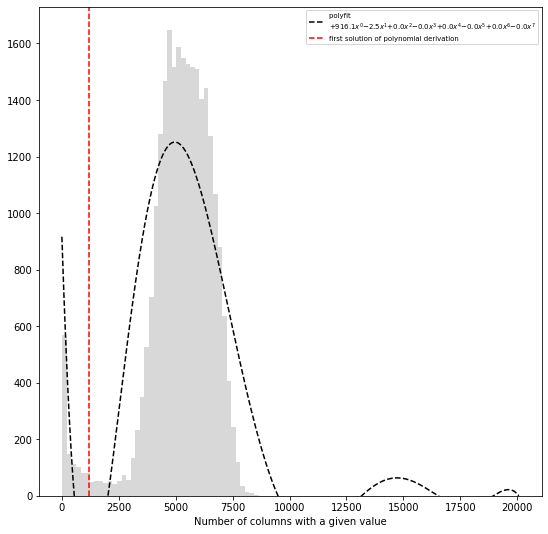

In [4]:
hic_data.filter_columns(draw_hist=True, min_count=10, by_mean=True, silent=True)

In [5]:
print('removed {:,} columns out of {:,} ({:.1f}%)'.format(len(hic_data.bads), len(hic_data),
                                                           len(hic_data.bads) / float(len(hic_data)) * 100))

removed 2,660 columns out of 27,269 (9.8%)


At 100 kb it makes no sense to view the full matrix (your matrix will have more cells than your screen have pixels), so it is much more informative to plot a specific region of the genome only using the `focus` parameter.

In [6]:
from pytadbit.mapping.analyze import hic_map

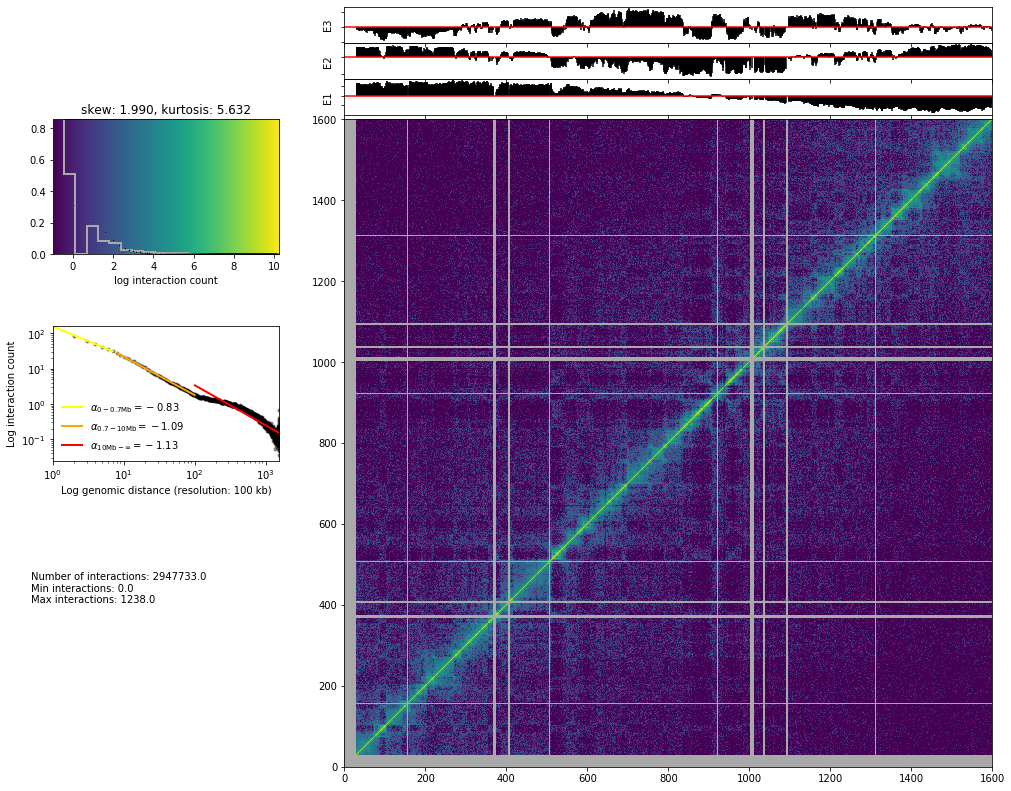

In [7]:
hic_map(hic_data, normalized=False, focus='chr3', show=True, cmap='viridis')

## Normalization algorithms

*__Note__: if columns with a lot of zeroes are present the ICE normalization will last very long to converge, and these low-coverage columns will present, at the end of the normalization, few cells with very high values of interaction*

### Iterative Correction and Eigenvector decomposition (ICE)

ICE normalization <a name="ref-1"/>[(Imakaev et al., 2012)](#cite-Imakaev2012a) assumes an equal experimental visibility of each bin and seeks iteratively for biases that equalize the sum of counts per bin in the matrix. At each iteration, a new matrix is generated by dividing each cell by the product of the sum of counts in its row times the sum of counts in its column. The process converges to a matrix in which all bins have identical sum.

If $W$ is the raw matrix, $N$ is its size, and $i$($j$) the index of the columns(rows), the normalized matrix $M$ is iteratively computed as:

$$M_{i,j} = \frac{W_{i,j}}{\sqrt{\sum_{n=0}^N{W_{i,n}} \times \sum_{n=0}^N{W_{n,j}}}}$$

This normalization has usually a quite strong effect, and visually the matrices look very smooth and regular.

In [8]:
hic_data.normalize_hic(iterations=100, max_dev=0.00001)

iterative correction
  - copying matrix
  - computing biases
          1083.000        5384.660      101635.000    0  17.87492
          4407.395        5483.780        8251.728    1   0.50475
          4560.550        5512.003        6238.145    2   0.17261
          5116.644        5521.481        6119.412    3   0.10829
          5173.833        5524.944        5781.389    4   0.06355
          5374.323        5526.241        5761.161    5   0.04251
          5380.193        5526.744        5621.079    6   0.02652
          5470.168        5526.942        5623.500    7   0.01747
          5465.095        5527.021        5561.686    8   0.01120
          5506.121        5527.053        5567.812    9   0.00737
          5500.600        5527.066        5539.771   10   0.00479
          5519.386        5527.071        5544.417   11   0.00314
          5515.770        5527.073        5531.733   12   0.00205
          5524.250        5527.074        5534.470   13   0.00134
          5522.

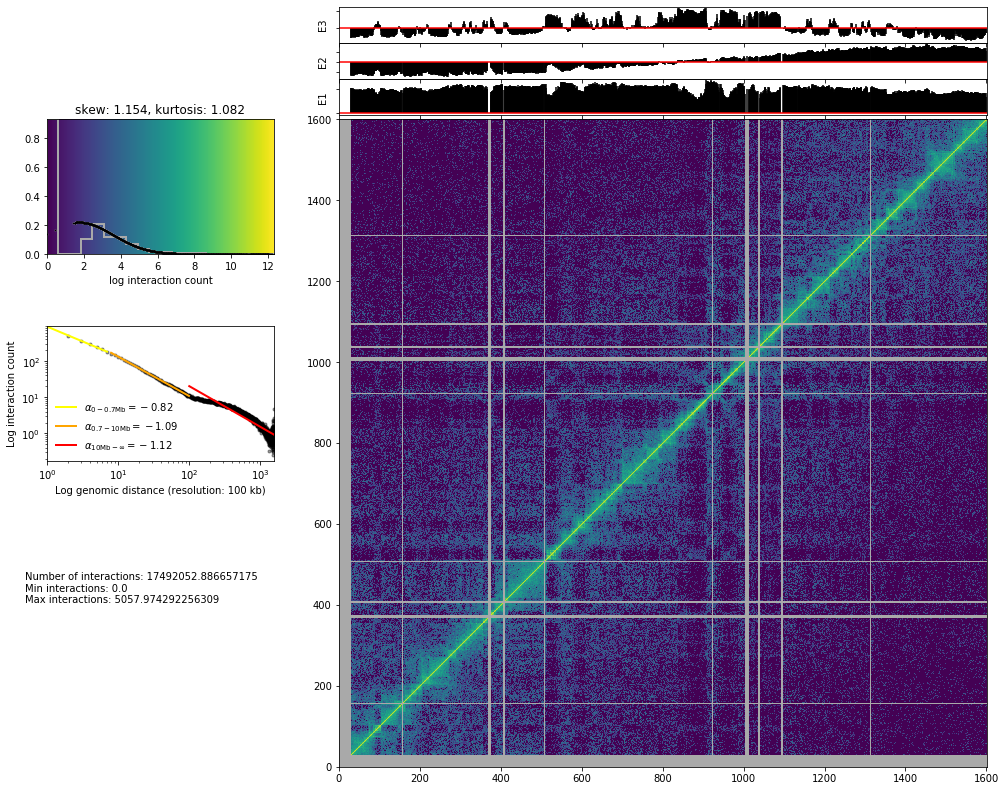

In [9]:
from pytadbit.mapping.analyze import hic_map

hic_map(hic_data, normalized=True, focus='chr3', show=True, cmap='viridis')

### Save biases

In [10]:
hic_data.save_biases('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}_ICE_{2}kb.biases'.format(
    cell, repl, reso // 1000))

### Vanilla coverage normalization

The vanilla normalization <a name="ref-2"/>[(Rao et al., 2014)](#cite-Rao2014) is a variation of the ICE where a single iteration is performed.

In [11]:
hic_data.normalize_hic(iterations=0, max_dev=0.00001)

iterative correction
  - copying matrix
  - computing biases
rescaling to factor 1
  - getting the sum of the matrix
    => 25061.997
  - rescaling biases


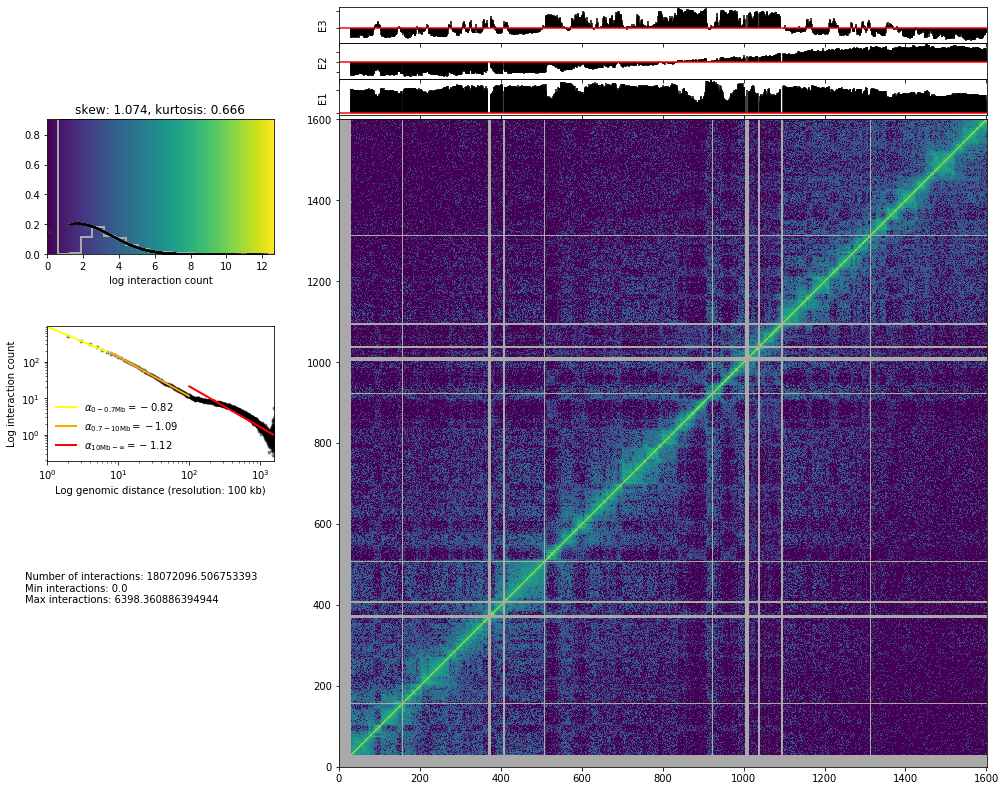

In [12]:
from pytadbit.mapping.analyze import hic_map

hic_map(hic_data, normalized=True, focus='chr3', show=True, cmap='viridis')

### Save biases

In [13]:
hic_data.save_biases('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}_Vanilla_{2}kb.biases'.format(
    cell, repl, reso // 1000))

### Square root vanilla coverage (SQRT) normalization

The SQRT vanilla normalization <a name="ref-2"/>[(Rao et al., 2014)](#cite-Rao2014) is a variation of the Vanilla coverage where each element in the matrix is divided by the square root of the product of sums of counts.

$$M_{i,j} = \frac{W_{i,j}}{\sqrt{\sum_{n=0}^N{W_{i,n}} \times \sum_{n=0}^N{W_{n,j}}}}$$

In [14]:
hic_data.normalize_hic(iterations=0, sqrt=True, max_dev=0.00001)

iterative correction
  - copying matrix
  - computing biases
rescaling to factor 1
  - getting the sum of the matrix
    => 1790593.806
  - rescaling biases


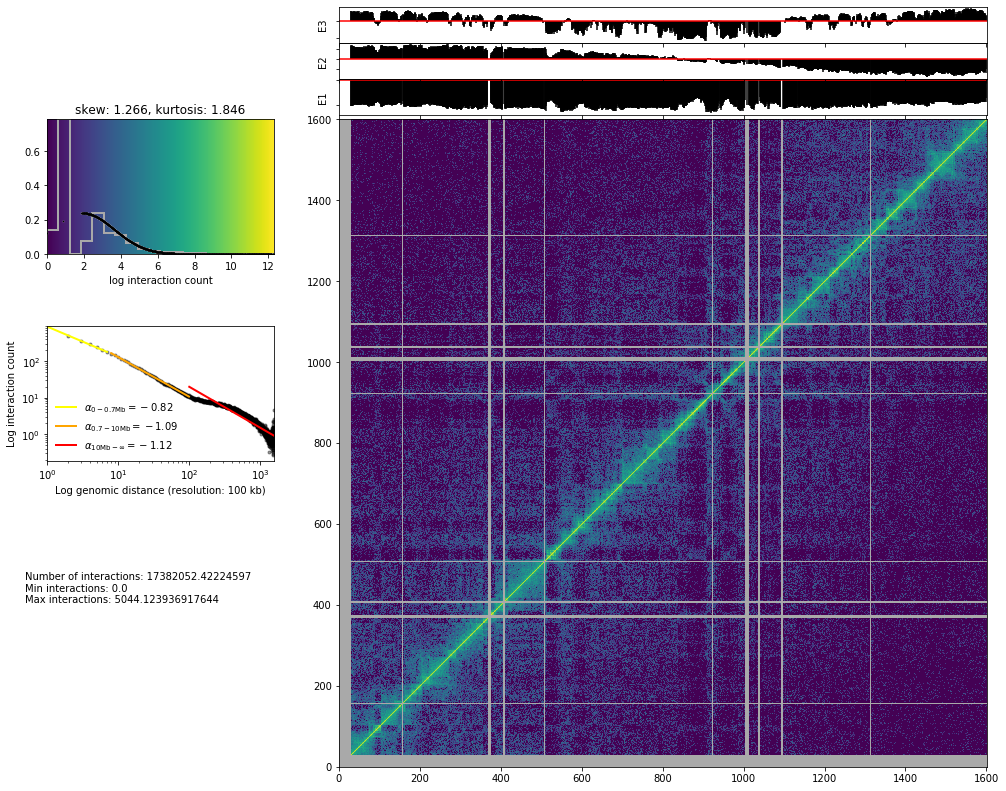

In [15]:
from pytadbit.mapping.analyze import hic_map

hic_map(hic_data, normalized=True, focus='chr3', show=True, cmap='viridis')

### Save biases

In [16]:
hic_data.save_biases('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}_SQRT_{2}kb.biases'.format(
    cell, repl, reso // 1000))

### OneD normalization

OneD normalization <a name="ref-3"/>[(Vidal et al., 2018)](#cite-Vidal2018) is based on fitting a non-linear model between the total amount of contacts per bin and the known biases:
 - GC content
 - number of RE sites (the most important bias, the more cut sites, the more mapped reads)
 - read mappability

As the estimation of each of this statistics is very important for the normalization, they are left outside the normalization function, in order to allow user to modify them.

In [17]:
from pytadbit.parsers.bed_parser          import parse_mappability_bedGraph
from pytadbit.utils.normalize_hic         import oneD
from pytadbit.mapping.restriction_enzymes import RESTRICTION_ENZYMES
from pytadbit.parsers.genome_parser       import parse_fasta, get_gc_content

In [18]:
fasta = 'genome/Mus_musculus-GRCm38.p6/Mus_musculus-GRCm38.p6.fa'
genome = parse_fasta(fasta, verbose=False)

get mappability ~2 min

In [19]:
f_mappability = 'genome/Mus_musculus-GRCm38.p6/Mus_musculus-GRCm38.p6.50mer.bedGraph'

mappability = parse_mappability_bedGraph(f_mappability, reso)

In [20]:
from functools import reduce

for c in genome:
    if not c in mappability:
        mappability[c] = [float('nan')] * (len(genome) // reso + 1)
    if len(mappability[c]) < len(genome) // reso + 1:
        mappability[c] += [float('nan')] * (
            (len(genome) // reso + 1) - len(mappability[c]))
mappability = reduce(lambda x, y: x + y,
                     (mappability.get(c, []) for c in genome))

get GC content ~ 30 sec

In [21]:
gc_content = get_gc_content(genome, reso, n_cpus=8)

compute r_sites ~30 sec

In [22]:
re_site = RESTRICTION_ENZYMES['MboI'].replace('|', '')

n_rsites  = []
for crm in genome:
    for pos in range(0, len(genome[crm]), reso):
        seq = genome[crm][pos:pos + reso + 400]
        n_rsites.append(seq.count(re_site))

In [23]:
sum_cols = [float('nan') if c in hic_data.bads else 
            sum(0.0 if l in hic_data.bads else hic_data[c, l] for l in range(len(hic_data))) 
            for c in range(len(hic_data))]

In [24]:
biases = oneD(tot=sum_cols, map=mappability, res=n_rsites, cg=gc_content)

In [25]:
hic_data.bias = list(biases)

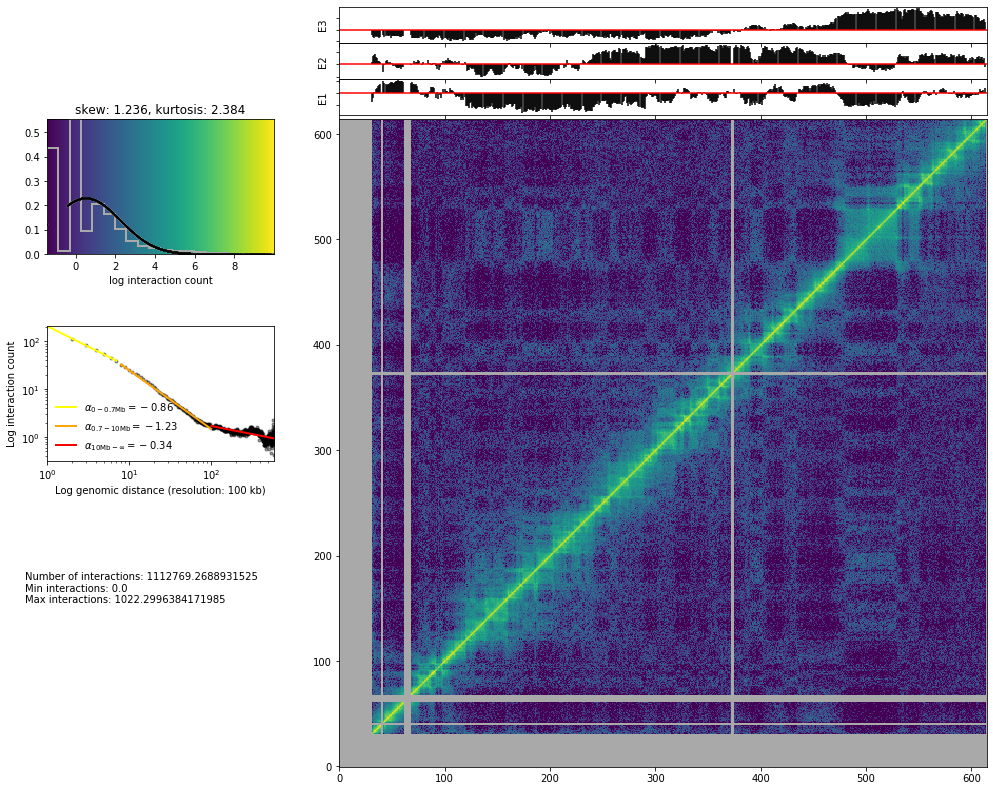

In [26]:
from pytadbit.mapping.analyze import hic_map

hic_map(hic_data, normalized=True, focus='chr19', show=True, cmap='viridis')

### Save biases

In [27]:
hic_data.save_biases('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}_oneD_{2}kb.biases'.format(
    cell, repl, reso // 1000))

### Comparison

By eye, the effect of choosing one normalization over an other is often very small

In [28]:
import matplotlib.pyplot as plt
import numpy as np
from pytadbit.utils.extraviews import plot_HiC_matrix

/home/dcastillo/miniconda2/envs/py3_tadbit/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log2
  """
/home/dcastillo/miniconda2/envs/py3_tadbit/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log2


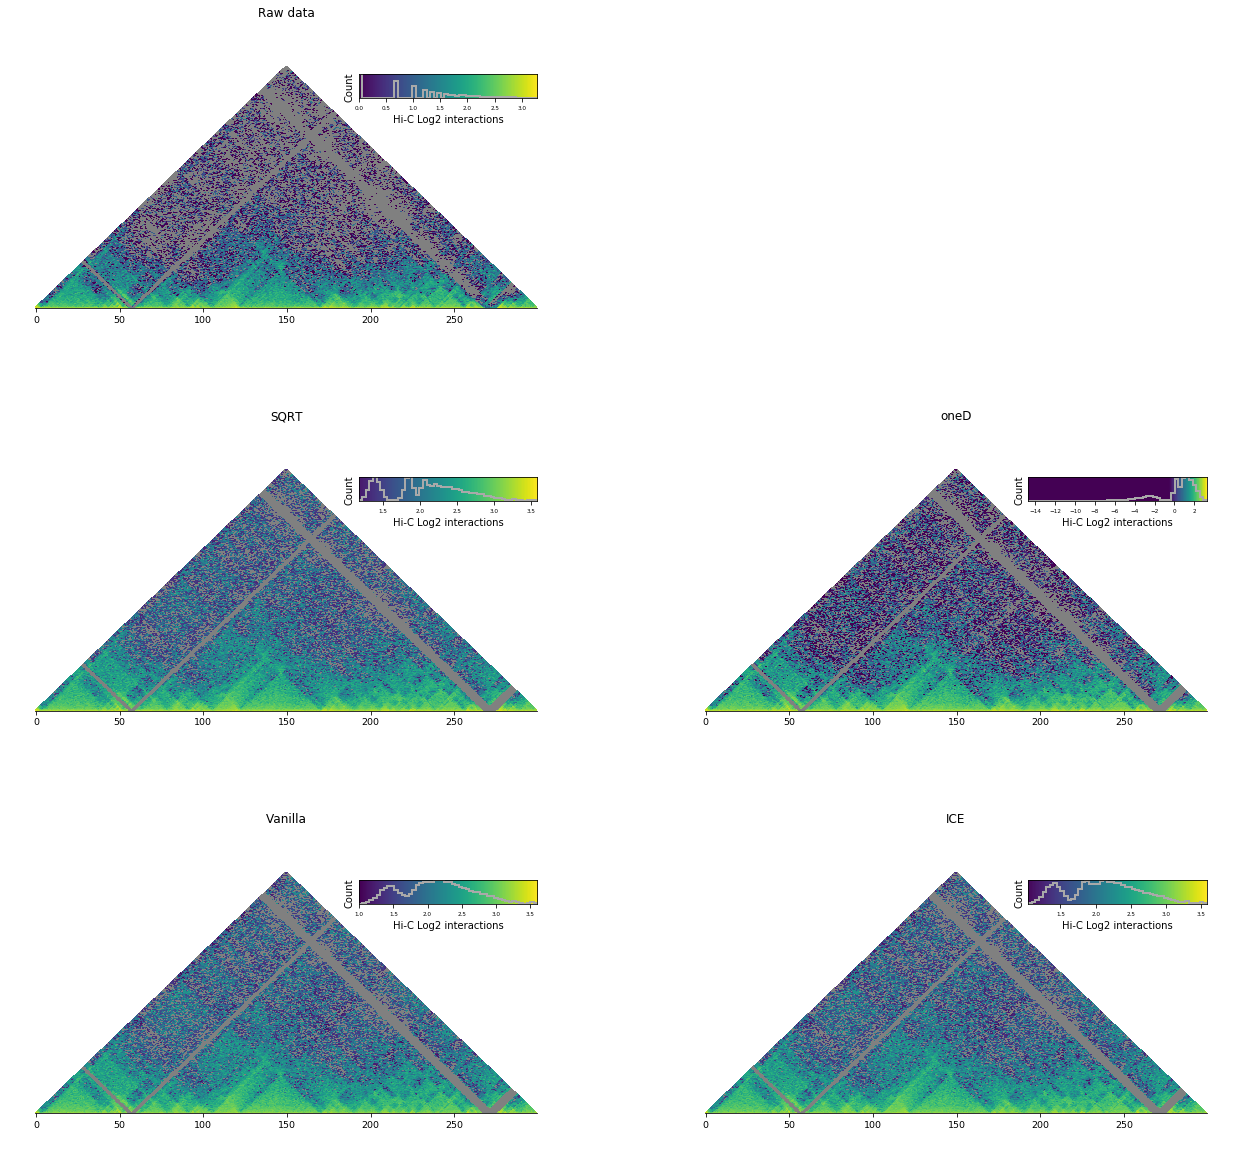

In [29]:
plt.figure(figsize=(22, 21))
axe = plt.subplot(3, 2, 1)
plt.title('Raw data')
matrix = hic_data.get_matrix(focus='chr3:10000000-40000000', normalized=False)
plot_HiC_matrix(np.log2(matrix), axe=axe,#  vmin=0.5,
                triangular=True)
axe.axis('off')
for num, norm in enumerate(['SQRT', 'oneD', 'Vanilla', 'ICE'], 3):
    # load biases
    hic_data.load_biases('results/fragment/{0}_{1}/03_filtering/valid_reads12_{0}_{1}_{3}_{2}kb.biases'.format(
    cell, repl, reso // 1000, norm))
    # retrieve data as matrix
    matrix = hic_data.get_matrix(focus='chr3:10000000-40000000', normalized=True, masked=True)
    # define subplot
    axe = plt.subplot(3, 2, num)
    # draw plot
    plt.title(norm)
    plot_HiC_matrix(np.log2(matrix), axe=axe, 
                    vmin=-0.5 if norm=='oneD' else 1,  # manually adjust color scale depending on the normalization
                    bad_color='grey', triangular=True)
    axe.axis('off')
plt.show()

### Other normalizations

ICE and Vanilla normalizations are widely used however other, more convoluted, normalizations <a name="ref-4"/>[(Hu et al., 2012)](#cite-hu2012hicnorm) <a name="ref-5"/>[(Yaffe and Tanay, 2011)](#cite-Yaffe2011) can be used outside TADbit and then loaded in TADbit as normalized matrices for further analysis.

### Best normalization

Which is the best normalization to use is a question that can not be answered easily because it depends on the type of data and the type of analysis.

Most of the time Hi-C experiments are conducted in different conditions and, for each, in several replicates. A good way to find the best normalization method may be to select the one that achieve to minimize the differences between replicates and maximize the differences between conditions (this in the context of the analysis to be performed).

<!--bibtex
@article{hu2012hicnorm,
  title={HiCNorm: removing biases in Hi-C data via Poisson regression},
  author={Hu, Ming and Deng, Ke and Selvaraj, Siddarth and Qin, Zhaohui and Ren, Bing and Liu, Jun S},
  journal={Bioinformatics},
  volume={28},
  number={23},
  pages={3131--3133},
  year={2012},
  publisher={Oxford Univ Press}
}
@article{Yaffe2011,
abstract = {Hi-C experiments measure the probability of physical proximity between pairs of chromosomal loci on a genomic scale. We report on several systematic biases that substantially affect the Hi-C experimental procedure, including the distance between restriction sites, the GC content of trimmed ligation junctions and sequence uniqueness. To address these biases, we introduce an integrated probabilistic background model and develop algorithms to estimate its parameters and renormalize Hi-C data. Analysis of corrected human lymphoblast contact maps provides genome-wide evidence for interchromosomal aggregation of active chromatin marks, including DNase-hypersensitive sites and transcriptionally active foci. We observe extensive long-range (up to 400 kb) cis interactions at active promoters and derive asymmetric contact profiles next to transcription start sites and CTCF binding sites. Clusters of interacting chromosomal domains suggest physical separation of centromere-proximal and centromere-distal regions. These results provide a computational basis for the inference of chromosomal architectures from Hi-C experiments.},
author = {Yaffe, Eitan and Tanay, Amos},
doi = {10.1038/ng.947},
file = {:home/fransua/.local/share/data/Mendeley Ltd./Mendeley Desktop/Downloaded/Yaffe, Tanay - 2011 - Probabilistic modeling of Hi-C contact maps eliminates systematic biases to characterize global chromosomal archit.pdf:pdf},
issn = {1546-1718},
journal = {Nature genetics},
keywords = {Binding Sites,Chromosomes,Cluster Analysis,Epigenesis,Genetic,Human,Humans,Lymphocytes,Lymphocytes: ultrastructure,Models,Probability},
mendeley-groups = {Research articles},
month = {nov},
number = {11},
pages = {1059--65},
pmid = {22001755},
title = {{Probabilistic modeling of Hi-C contact maps eliminates systematic biases to characterize global chromosomal architecture.}},
url = {http://www.ncbi.nlm.nih.gov/pubmed/22001755},
volume = {43},
year = {2011}
}
@article{Imakaev2012a,
abstract = {Extracting biologically meaningful information from chromosomal interactions obtained with genome-wide chromosome conformation capture (3C) analyses requires the elimination of systematic biases. We present a computational pipeline that integrates a strategy to map sequencing reads with a data-driven method for iterative correction of biases, yielding genome-wide maps of relative contact probabilities. We validate this ICE (iterative correction and eigenvector decomposition) technique on published data obtained by the high-throughput 3C method Hi-C, and we demonstrate that eigenvector decomposition of the obtained maps provides insights into local chromatin states, global patterns of chromosomal interactions, and the conserved organization of human and mouse chromosomes.},
author = {Imakaev, Maxim V and Fudenberg, Geoffrey and McCord, Rachel Patton and Naumova, Natalia and Goloborodko, Anton and Lajoie, Bryan R and Dekker, Job and Mirny, Leonid A},
doi = {10.1038/nmeth.2148},
file = {:home/fransua/.local/share/data/Mendeley Ltd./Mendeley Desktop/Downloaded/Imakaev et al. - 2012 - Iterative correction of Hi-C data reveals hallmarks of chromosome organization.pdf:pdf},
issn = {1548-7105},
journal = {Nature methods},
keywords = {Hi-C},
mendeley-groups = {stats/Hi-C,Research articles},
mendeley-tags = {Hi-C},
month = {oct},
number = {10},
pages = {999--1003},
pmid = {22941365},
title = {{Iterative correction of Hi-C data reveals hallmarks of chromosome organization.}},
url = {http://www.ncbi.nlm.nih.gov/pubmed/22941365},
volume = {9},
year = {2012}
}
@article{Rao2014,
author = {Rao, Suhas S P and Huntley, Miriam H and Durand, Neva C and Stamenova, Elena K and Bochkov, Ivan D. and {James T. Robinson} and Sanborn, Adrian L. and Machol, Ido and Omer, Arina D. and Lander, Eric S. and Lieberman-Aiden, Erez},
doi = {10.1016/j.cell.2014.11.021},
file = {:home/fransua/.local/share/data/Mendeley Ltd./Mendeley Desktop/Downloaded/Rao et al. - 2014 - A 3D Map of the Human Genome at Kilobase Resolution Reveals Principles of Chromatin Looping.pdf:pdf},
issn = {0092-8674},
journal = {Cell},
keywords = {Hi-C},
mendeley-groups = {Research articles,projects/GEVO/CTCF},
mendeley-tags = {Hi-C},
number = {7},
pages = {1665--1680},
pmid = {25497547},
publisher = {Elsevier Inc.},
title = {{A 3D Map of the Human Genome at Kilobase Resolution Reveals Principles of Chromatin Looping}},
url = {http://dx.doi.org/10.1016/j.cell.2014.11.021},
volume = {159},
year = {2014}
}

-->

### References

<a name="cite-Imakaev2012a"/><sup>[^](#ref-1) </sup>Imakaev, Maxim V and Fudenberg, Geoffrey and McCord, Rachel Patton and Naumova, Natalia and Goloborodko, Anton and Lajoie, Bryan R and Dekker, Job and Mirny, Leonid A. 2012. _Iterative correction of Hi-C data reveals hallmarks of chromosome organization._. [URL](http://www.ncbi.nlm.nih.gov/pubmed/22941365)

<a name="cite-Rao2014"/><sup>[^](#ref-2) </sup>Rao, Suhas S P and Huntley, Miriam H and Durand, Neva C and Stamenova, Elena K and Bochkov, Ivan D. and James T. Robinson and Sanborn, Adrian L. and Machol, Ido and Omer, Arina D. and Lander, Eric S. and Lieberman-Aiden, Erez. 2014. _A 3D Map of the Human Genome at Kilobase Resolution Reveals Principles of Chromatin Looping_. [URL](http://dx.doi.org/10.1016/j.cell.2014.11.021)

<a name="cite-Vidal2018"/><sup>[^](#ref-3) </sup>Enrique Vidal, François le Dily, Javier Quilez, Ralph Stadhouders, Yasmina Cuartero, Thomas Graf, Marc A Marti-Renom, Miguel Beato, Guillaume J Filion. 2018. _OneD: increasing reproducibility of Hi-C samples with abnormal karyotypes_. [URL](https://doi.org/10.1093/nar/gky064)

<a name="cite-hu2012hicnorm"/><sup>[^](#ref-4) </sup>Hu, Ming and Deng, Ke and Selvaraj, Siddarth and Qin, Zhaohui and Ren, Bing and Liu, Jun S. 2012. _HiCNorm: removing biases in Hi-C data via Poisson regression_.

<a name="cite-Yaffe2011"/><sup>[^](#ref-5) </sup>Yaffe, Eitan and Tanay, Amos. 2011. _Probabilistic modeling of Hi-C contact maps eliminates systematic biases to characterize global chromosomal architecture._. [URL](http://www.ncbi.nlm.nih.gov/pubmed/22001755)

